# 3.8.1 Monotonic XGBoost Model
#### and comparison with non-monotonic model

## 1) Load Required Libraries

In [1]:
library("dplyr")
library("ggplot2")
library("ROSE")
library("xgboost")
library("gbm")
library("Matrix")
library("pdp") 
library("caret")
library("mltools")
library("data.table")
library("pROC")
library("PRROC")
library("rBayesianOptimization")
library("DiagrammeR")
library("MLmetrics")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loaded ROSE 0.0-3


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice

Loaded gbm 2.1.5
Loading required package: lattice

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘PRROC’

The following object is masked from ‘package:ROSE’:

    roc.curve


Attaching package: ‘MLmetrics’

The following objects are masked from ‘package:caret’:

    MAE, RMSE

The following object is masked from ‘package:base’:

    Recall



## 2) Load Data

In [2]:
train.df <- read.csv(file="./data/TrainData.csv", header=TRUE, sep=",")
train.orig.df <- train.df
glimpse(train.df)

Observations: 204,640
Variables: 30
$ X.1                                    <int> 1, 2, 3, 4, 8, 9, 10, 11, 12, …
$ X                                      <int> 1, 2, 3, 4, 8, 9, 10, 11, 12, …
$ loan_amnt                              <int> 7500, 5600, 11200, 25000, 5000…
$ term                                   <fct>  36 months,  36 months,  36 mo…
$ int_rate                               <dbl> 13.87, 18.04, 11.34, 15.25, 12…
$ installment                            <dbl> 255.86, 202.57, 368.48, 869.70…
$ grade                                  <fct> D, G, C, E, C, B, A, B, B, C, …
$ home_ownership                         <fct> MORTGAGE, OWN, RENT, MORTGAGE,…
$ annual_inc                             <dbl> 165000, 45000, 44400, 150000, …
$ verification_status                    <fct> Not Verified, Not Verified, No…
$ pymnt_plan                             <fct> n, n, n, n, n, n, n, n, n, n, …
$ purpose                                <fct> Others, home_improvement, debt…
$ dti           

In [3]:
test.df <- read.csv(file="./data/TestData.csv", header=TRUE, sep=",")
test.orig.df <- test.df
glimpse(test.df)

Observations: 51,159
Variables: 30
$ X.1                                    <int> 5, 6, 7, 13, 15, 19, 30, 32, 3…
$ X                                      <int> 5, 6, 7, 13, 15, 19, 30, 32, 3…
$ loan_amnt                              <int> 12200, 9325, 15000, 15000, 400…
$ term                                   <fct>  36 months,  36 months,  36 mo…
$ int_rate                               <dbl> 12.29, 12.53, 11.89, 13.16, 12…
$ installment                            <dbl> 406.91, 312.08, 497.46, 506.56…
$ grade                                  <fct> C, C, B, C, C, B, B, D, A, B, …
$ home_ownership                         <fct> OWN, MORTGAGE, MORTGAGE, MORTG…
$ annual_inc                             <dbl> 38400, 85000, 90000, 150000, 8…
$ verification_status                    <fct> Not Verified, Not Verified, Ve…
$ pymnt_plan                             <fct> n, n, n, n, n, n, n, n, n, n, …
$ purpose                                <fct> home_improvement, small_busine…
$ dti            

## 3) Transform Data for Modelling

### 3.1) Basic Transforms

Remove `X.1`, `X`, `pymnt_plan`, `application_type` and `profit` columns

In [4]:
train.df$X.1 <- NULL
train.df$X <- NULL
train.df$GeoName <- NULL
train.df$pymnt_plan <- NULL
train.df$application_type <- NULL
train.df$profit <- NULL

In [5]:
test.df$X.1 <- NULL
test.df$X <- NULL
test.df$GeoName <- NULL
test.df$pymnt_plan <- NULL
test.df$application_type <- NULL
test.df$profit <- NULL

Convert all factor levels to uppercase and replace spaces for underscores to make them more readable

In [6]:
train.df <- train.df %>% mutate(term = factor(term, labels = c('36MO', '60MO')),
        verification_status = factor(verification_status, labels = c('NOT_VERIFIED', 'SOURCE_VERIFIED', 'VERIFIED')),
        purpose = factor(purpose, labels = c('CREDIT_CARD', 'DEBT_CONSOLIDATION', 'HOME_IMPROVEMENT', 'MAJOR_PURCHASE', 'OTHERS', 'SMALL_BUSINESS')),
        initial_list_status = factor(initial_list_status, labels = c('F', 'W')),
        regions = factor(regions, labels = c('MIDWEST', 'NORTHEAST', 'SOUTH', 'WEST')))

In [7]:
test.df <- test.df %>% mutate(term = factor(term, labels = c('36MO', '60MO')),
        verification_status = factor(verification_status, labels = c('NOT_VERIFIED', 'SOURCE_VERIFIED', 'VERIFIED')),
        purpose = factor(purpose, labels = c('CREDIT_CARD', 'DEBT_CONSOLIDATION', 'HOME_IMPROVEMENT', 'MAJOR_PURCHASE', 'OTHERS', 'SMALL_BUSINESS')),
        initial_list_status = factor(initial_list_status, labels = c('F', 'W')),
        regions = factor(regions, labels = c('MIDWEST', 'NORTHEAST', 'SOUTH', 'WEST')))

Rename external source columns for readability and ease of programmatic reference

In [8]:
train.df <- train.df %>% rename("compensation_of_employees" = "Compensation.of.employees", 
                           "gross_operating_surplus" = "Gross.operating.surplus",
                           "per_capita_real_gdp_by_state" = "Per.capita.real.GDP.by.state",
                           "quantity_indexes_for_real_gdp_by_state" = "Quantity.indexes.for.real.GDP.by.state",
                           "real_gdp_by_state" = "Real.GDP.by.state",
                           "subsidies" = "Subsidies",
                           "taxes_on_production_and_imports" = "Taxes.on.production.and.imports")

In [9]:
test.df <- test.df %>% rename("compensation_of_employees" = "Compensation.of.employees", 
                           "gross_operating_surplus" = "Gross.operating.surplus",
                           "per_capita_real_gdp_by_state" = "Per.capita.real.GDP.by.state",
                           "quantity_indexes_for_real_gdp_by_state" = "Quantity.indexes.for.real.GDP.by.state",
                           "real_gdp_by_state" = "Real.GDP.by.state",
                           "subsidies" = "Subsidies",
                           "taxes_on_production_and_imports" = "Taxes.on.production.and.imports")

Glimpse newly transformed dataframes

In [10]:
glimpse(train.df)

Observations: 204,640
Variables: 24
$ loan_amnt                              <int> 7500, 5600, 11200, 25000, 5000…
$ term                                   <fct> 36MO, 36MO, 36MO, 36MO, 36MO, …
$ int_rate                               <dbl> 13.87, 18.04, 11.34, 15.25, 12…
$ installment                            <dbl> 255.86, 202.57, 368.48, 869.70…
$ grade                                  <fct> D, G, C, E, C, B, A, B, B, C, …
$ home_ownership                         <fct> MORTGAGE, OWN, RENT, MORTGAGE,…
$ annual_inc                             <dbl> 165000, 45000, 44400, 150000, …
$ verification_status                    <fct> NOT_VERIFIED, NOT_VERIFIED, NO…
$ purpose                                <fct> OTHERS, HOME_IMPROVEMENT, DEBT…
$ dti                                    <dbl> 20.95, 25.84, 6.92, 6.82, 18.2…
$ open_acc                               <int> 15, 11, 9, 5, 9, 5, 6, 12, 7, …
$ pub_rec                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ total_acc     

In [11]:
glimpse(test.df)

Observations: 51,159
Variables: 24
$ loan_amnt                              <int> 12200, 9325, 15000, 15000, 400…
$ term                                   <fct> 36MO, 36MO, 36MO, 36MO, 36MO, …
$ int_rate                               <dbl> 12.29, 12.53, 11.89, 13.16, 12…
$ installment                            <dbl> 406.91, 312.08, 497.46, 506.56…
$ grade                                  <fct> C, C, B, C, C, B, B, D, A, B, …
$ home_ownership                         <fct> OWN, MORTGAGE, MORTGAGE, MORTG…
$ annual_inc                             <dbl> 38400, 85000, 90000, 150000, 8…
$ verification_status                    <fct> NOT_VERIFIED, NOT_VERIFIED, VE…
$ purpose                                <fct> HOME_IMPROVEMENT, SMALL_BUSINE…
$ dti                                    <dbl> 9.31, 18.58, 17.11, 4.06, 12.2…
$ open_acc                               <int> 4, 16, 18, 8, 6, 12, 6, 8, 7, …
$ pub_rec                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ total_acc      

### 3.2) One-hot encoded version (for monotonic constraints)

In [12]:
train.1hot.df <- one_hot(as.data.table(train.df))
glimpse(train.1hot.df)

Observations: 204,640
Variables: 44
$ loan_amnt                              <int> 7500, 5600, 11200, 25000, 5000…
$ term_36MO                              <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ term_60MO                              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ int_rate                               <dbl> 13.87, 18.04, 11.34, 15.25, 12…
$ installment                            <dbl> 255.86, 202.57, 368.48, 869.70…
$ grade_A                                <int> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, …
$ grade_B                                <int> 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, …
$ grade_C                                <int> 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, …
$ grade_D                                <int> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_E                                <int> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, …
$ grade_F                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_G                                <int> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, …
$ home_ownership

In [13]:
test.1hot.df <- one_hot(as.data.table(test.df))
glimpse(test.1hot.df)

Observations: 51,159
Variables: 44
$ loan_amnt                              <int> 12200, 9325, 15000, 15000, 400…
$ term_36MO                              <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ term_60MO                              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ int_rate                               <dbl> 12.29, 12.53, 11.89, 13.16, 12…
$ installment                            <dbl> 406.91, 312.08, 497.46, 506.56…
$ grade_A                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, …
$ grade_B                                <int> 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, …
$ grade_C                                <int> 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, …
$ grade_D                                <int> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, …
$ grade_E                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_F                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_G                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ home_ownership_

In [14]:
write.csv(train.1hot.df, file = "./data/new.train.1hot.df.csv")
write.csv(test.1hot.df, file = "./data/new.test.1hot.df.csv")
write.csv(train.df, file = "./data/new.train.df.csv")
write.csv(test.df, file = "./data/new.test.df.csv")

### 3.3) Calculate Sampled Medians (for Cost Sensitive Learning & Evaluation )

Calculate median sample returns

In [15]:
mreturns <- mean((train.df %>% mutate(returns = (installment * ifelse(term=='36MO', 36, 60)) - loan_amnt))$returns)
mreturns

[1] 4120.554

Median sample loan amount

In [16]:
mloan_amnt <- mean(train.df$loan_amnt)
mloan_amnt

[1] 13522.29

### 3.4) Generate Y/X Sets for all versions

Remove returns from all training set to

In [17]:
y_train <- subset(train.1hot.df, select=default)
x_train <- subset(train.df, select=-c(default))
x_train.1hot <- subset(train.1hot.df, select=-c(default))
y_test <- subset(test.1hot.df, select=default)
x_test <- subset(test.df, select=-c(default))
x_test.1hot <- subset(test.1hot.df, select=-c(default))

### 3.7) Create Constraint Matrix

**Calculate the Correlation Direction Between Response and Predictors**

In [18]:
mono <- cor(y_train, x_train.1hot, method = 'spearman', use="pairwise.complete.obs") / abs(cor(y_train, x_train.1hot, method = 'spearman', use="pairwise.complete.obs"))

Take a look at the constraints

In [19]:
glimpse(as.data.frame(mono))

Observations: 1
Variables: 43
$ loan_amnt                              <dbl> 1
$ term_36MO                              <dbl> -1
$ term_60MO                              <dbl> 1
$ int_rate                               <dbl> 1
$ installment                            <dbl> 1
$ grade_A                                <dbl> -1
$ grade_B                                <dbl> -1
$ grade_C                                <dbl> 1
$ grade_D                                <dbl> 1
$ grade_E                                <dbl> 1
$ grade_F                                <dbl> 1
$ grade_G                                <dbl> 1
$ home_ownership_MORTGAGE                <dbl> -1
$ home_ownership_OWN                     <dbl> 1
$ home_ownership_RENT                    <dbl> 1
$ annual_inc                             <dbl> -1
$ verification_status_NOT_VERIFIED       <dbl> -1
$ verification_status_SOURCE_VERIFIED    <dbl> 1
$ verification_status_VERIFIED           <dbl> 1
$ purpose_CREDIT_CARD            

### 3.8) Create DMatrixes

In [20]:
dtrain.1hot <- xgb.DMatrix(data = data.matrix(x_train.1hot), label = data.matrix(y_train))
dtrain <- xgb.DMatrix(data = data.matrix(x_train), label = data.matrix(y_train))

### 3.9) Create Folds on Sampling

In [21]:
seedNum <- 19
cv_folds <- KFold(y_train$default, nfolds = 5, stratified = FALSE, seed=seedNum)

## 4) Modelling

### 4.1) Monotonic Constrained XGBoost

#### 4.1.1) Perform Hyperparameter Tuning with Bayesian Optimization and Cross Validation on the Training Data Sample

Optimize the PR AUC

In [22]:
xgb.mono.cv.bayes <- function(nround, max_depth, min_child_weight, eta, gamma) { # subsample, colsample_bytree, max_delta_step
    xgb.getLift <- function(preds, dtrain) {
        labels <- getinfo(dtrain, "label")
        lift <- getLift(preds, labels, thresholds[i])
        return(list(metric = "Lift", value = lift))
    }
    params <- list(
                    booster = "gbtree", #"gblinear", "dart"
                    max_depth = max_depth,
                    min_child_weight = min_child_weight,
                    eta = eta,
                    gamma = gamma,
                    subsample = 0.9, #subsample, 
                    colsample_bytree = 0.8, #colsample_bytree,
                    #max_delta_step = max_delta_step,
                    #lambda = 1, 
                    #alpha = 0,
                    objective = "binary:logistic",
                    eval_metric = "aucpr", 
                    monotone_constraints = mono
                 )
    cv <- xgb.cv(params = params, data = dtrain.1hot, folds = cv_folds, nrounds = 300, 
                 early_stopping_rounds = 20, maximize = TRUE, verbose = TRUE, print_every_n=20)
    return(list(Score = cv$evaluation_log$test_aucpr_mean[cv$best_iteration], Pred=cv$best_iteration))
}

In [23]:
stime <- Sys.time()
xgb.mono.cv.bayes.opt <- BayesianOptimization(xgb.mono.cv.bayes,
                              bounds = list(max_depth = c(3L, 15L), 
                                            min_child_weight = c(1L, 7L),
                                            eta=c(0.05, 0.3),
                                            gamma = c(0.0, 0.4) #,
                                            #subsample = c(0.6, 0.9),
                                            #colsample_bytree=c(0.3, 0.7),
                                            #max_delta_step=c(1L, 10L)
                                        ),
                              init_grid_dt = NULL, init_points = 10, n_iter = 10,
                              acq = "ucb", kappa = 2.576, eps = 0.0, verbose = FALSE)
print(Sys.time() - stime)


 Best Parameters Found: 
Round = 2	max_depth = 5.0000	min_child_weight = 2.0000	eta = 0.1703	gamma = 0.3935	Value = 0.3490 
Time difference of 46.96268 mins


**Bayesian Optimization History**

In [24]:
xgb.mono.cv.bayes.opt$History

Round,max_depth,min_child_weight,eta,gamma,Value
1,12,6,0.24412329,0.133080461,0.3482882
2,5,2,0.17025765,0.393479593,0.3489536
3,9,3,0.09932515,0.338871139,0.3487988
4,12,2,0.09238451,0.231440735,0.3487566
5,6,4,0.21399187,0.235047035,0.3484740
6,13,4,0.29085539,0.280479506,0.3473796
7,9,2,0.28628159,0.076092796,0.3468610
8,9,5,0.24449615,0.015563134,0.3473460
9,8,5,0.22571625,0.159017075,0.3477340
10,5,4,0.13333981,0.243278985,0.3482796


**Bayesian Optimization Best Parameters**

In [25]:
xgb.mono.cv.bayes.opt$Best_Par

max_depth min_child_weight              eta            gamma 
       5.0000000        2.0000000        0.1702577        0.3934796

**Set Optimal # Rounds**

In [26]:
xgb.mono.cv.bayes.opt.nrounds <- xgb.mono.cv.bayes.opt$Pred[[which.max(xgb.mono.cv.bayes.opt$History$Value)]]
xgb.mono.cv.bayes.opt.nrounds

[1] 153

#### 4.1.2) Perform Cost Sensitive Learning with Cross Validation on the Training Data Sample

**Objective Functions to Test**

In [27]:
#To Minimize
getCost <- function(obs, pred, threshold = 0.5) {
    tp_num <- sum(obs == 1 & obs == pred) #No Value assigned
    tn_num <- sum(obs == 0 & obs == pred) #No Value assigned
    fp_num <- sum(obs == 0 & obs != pred) #Value of median loan_amnt 
    fn_num <- sum(obs == 1 & obs != pred) #Value of median returns
    profit <- (tn_num * mreturns) + (fn_num * mloan_amnt)
    return(profit)
}

#To Maximize
getProfit <- function(obs, pred, threshold = 0.5) {
    pred <- ifelse(pred >= threshold, 1, 0)
    tp_num <- sum(obs == 1 & obs == pred) #No Value assigned
    tn_num <- sum(obs == 0 & obs == pred) #Value of median returns
    fp_num <- sum(obs == 0 & obs != pred) #No Value assigned
    fn_num <- sum(obs == 1 & obs != pred) #Value of median loan_amnt
    #print(sprintf("%s, %s, %s, %s", tp_num, tn_num, fp_num, fn_num))
    profit <- (tn_num * mreturns) - (fn_num * mloan_amnt)
    return(profit)
}

# Predict non-returning for everyone
getBenchmarkProfit <- function(obs) { 
  n <- length(obs)
  getProfit(obs, rep(0, times = n))
}

getLift <- function(probs, labels, thresh) {
    pred_profit <- as.numeric(getProfit(obs = labels,
                                      pred = probs,
                                      threshold = thresh))
    naive_profit <- as.numeric(getBenchmarkProfit(labels))
    profit_lift <- pred_profit/naive_profit
    #print(sprintf("%.2f / %.2f = %.4f", pred_profit, naive_profit, profit_lift))
    return(profit_lift)
}

**Custom Cost Sensitive Learning Function**

In [28]:
CSL <- function(params, data, nfold, nrounds, tstart, tend, tinterval, feval = "lift", verbose = FALSE, print_every_n = 50){
    thresholds <- seq(tstart, tend, by = tinterval)
    performance <- vector(length = length(thresholds))
    for(i in 1:length(thresholds)) {
        print(paste(i, ":", thresholds[i]))
        xgb.getCost <- function(preds, dtrain) {
            labels <- getinfo(dtrain, "label")
            cost <- getCost(labels, preds, thresholds[i])
            return(list(metric = "Cost", value = cost))
        }
        xgb.getLift <- function(preds, dtrain) {
            labels <- getinfo(dtrain, "label")
            lift <- getLift(preds, labels, thresholds[i])
            return(list(metric = "Lift", value = lift))
        }
        # train the model again using the current threshold 
        if (feval == "lift"){
            xgb.csl <- xgb.cv(params = params, data = data, nfold = nfold,
                            nrounds = nrounds, feval = xgb.getLift, maximize = TRUE, 
                            early_stopping_rounds = 10, verbose = verbose, print_every_n = print_every_n)   
        }else{
            xgb.csl <- xgb.cv(params = params, data = data, nfold = nfold,
                            nrounds = nrounds, feval = xgb.getCost, maximize = FALSE, 
                            early_stopping_rounds = 10, verbose = verbose, print_every_n = print_every_n)  
        }
        # store results
        performance[i] <- as.data.frame(xgb.csl$evaluation_log)[xgb.csl$best_iteration,4]
    }
    return(list("thresholds" = thresholds, "performance" = performance))
}

**Run CSL on a 0.003 threshold interval**

In [29]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.mono.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.mono.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.mono.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.mono.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1,
                monotone_constraints = mono
              )
stime <- Sys.time()
xgb.mono.CSL.cv.opt1 <- CSL(params, dtrain.1hot, 5, xgb.mono.cv.bayes.opt.nrounds, 
                           0.1, 0.69, 0.03, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.1"
[1] "2 : 0.13"
[1] "3 : 0.16"
[1] "4 : 0.19"
[1] "5 : 0.22"
[1] "6 : 0.25"
[1] "7 : 0.28"
[1] "8 : 0.31"
[1] "9 : 0.34"
[1] "10 : 0.37"
[1] "11 : 0.4"
[1] "12 : 0.43"
[1] "13 : 0.46"
[1] "14 : 0.49"
[1] "15 : 0.52"
[1] "16 : 0.55"
[1] "17 : 0.58"
[1] "18 : 0.61"
[1] "19 : 0.64"
[1] "20 : 0.67"
Time difference of 13.39847 mins


**Plot the lift for every threshold in the 0.10-0.69 range**

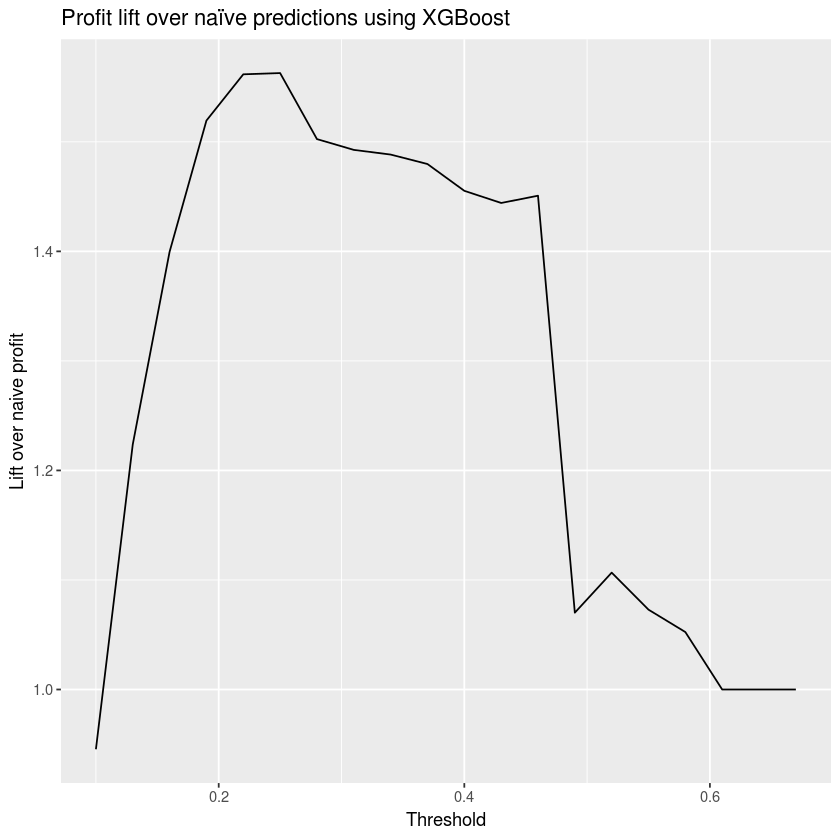

In [30]:
xgb.mono.CSL.cv.opt1.df <- as.data.frame(xgb.mono.CSL.cv.opt1)
ggplot(xgb.mono.CSL.cv.opt1.df, aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.03 scale**

In [31]:
xgb.mono.CSL.cv.opt1.threshold <- xgb.mono.CSL.cv.opt1.df$thresholds[which.max(xgb.mono.CSL.cv.opt1.df$performance)]
xgb.mono.CSL.cv.opt1.threshold

[1] 0.25

**Get more granular at a 0.005 threshold level**

In [32]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.mono.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.mono.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.mono.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.mono.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1,
                monotone_constraints = mono
              )
stime <- Sys.time()
xgb.mono.CSL.cv.opt2 <- CSL(params, dtrain.1hot, 5, xgb.mono.cv.bayes.opt.nrounds, 
                           xgb.mono.CSL.cv.opt1.threshold - 0.03, xgb.mono.CSL.cv.opt1.threshold + 0.03, 0.005, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.22"
[1] "2 : 0.225"
[1] "3 : 0.23"
[1] "4 : 0.235"
[1] "5 : 0.24"
[1] "6 : 0.245"
[1] "7 : 0.25"
[1] "8 : 0.255"
[1] "9 : 0.26"
[1] "10 : 0.265"
[1] "11 : 0.27"
[1] "12 : 0.275"
[1] "13 : 0.28"
Time difference of 9.208706 mins


**Plot the lift for every threshold in the 0.13-0.19 range**

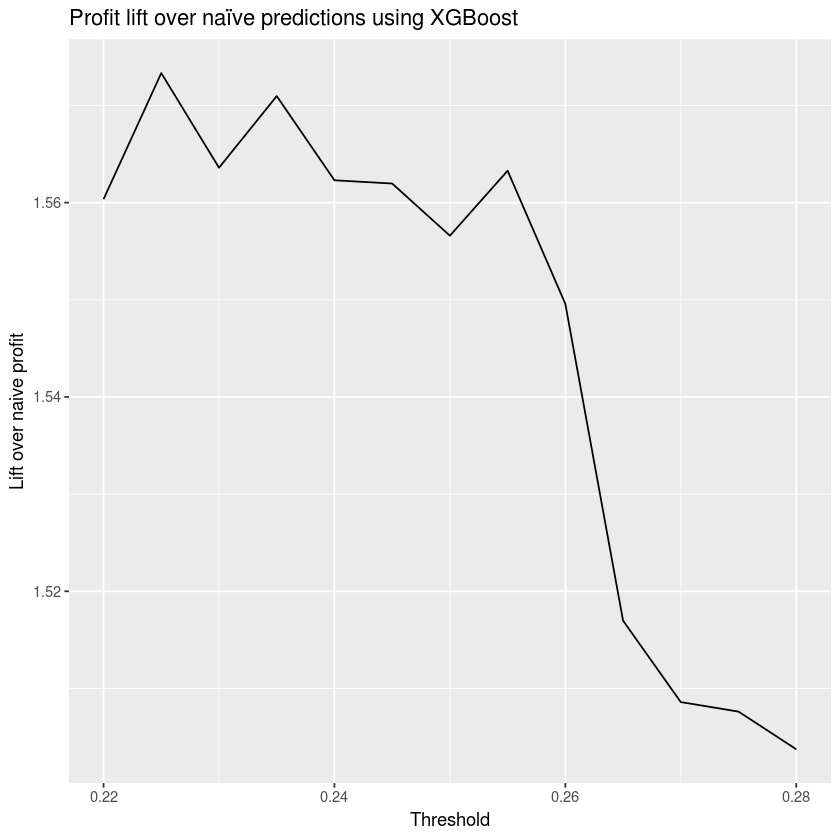

In [33]:
xgb.mono.CSL.cv.opt2.df <- as.data.frame(xgb.mono.CSL.cv.opt2)
ggplot(xgb.mono.CSL.cv.opt2.df, aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.005 scale**

In [34]:
xgb.mono.CSL.cv.opt2.threshold <- xgb.mono.CSL.cv.opt2.df$thresholds[which.max(xgb.mono.CSL.cv.opt2.df$performance)]
xgb.mono.CSL.cv.opt2.threshold

[1] 0.225

#### 4.1.3) Run & Test XGBoost on Optimal Params but on Full Training Set

**Set Optimal Params for Monotonic**

In [35]:
xgb.mono.cv.bayes.opt.params <- list(
    booster = "gbtree",
    max_depth = xgb.mono.cv.bayes.opt$Best_Par["max_depth"],
    min_child_weight = xgb.mono.cv.bayes.opt$Best_Par["min_child_weight"],
    eta = xgb.mono.cv.bayes.opt$Best_Par["eta"],
    gamma = xgb.mono.cv.bayes.opt$Best_Par["gamma"],
    subsample = 0.9, #xgb.mono.cv.bayes.opt$Best_Par["subsample"],
    colsample_bytree = 0.8, #xgb.mono.cv.bayes.opt$Best_Par["colsample_bytree"],
    #max_delta_step = xgb.mono.cv.bayes.opt$Best_Par["max_delta_step"], 
    objective = "binary:logistic",
    eval_metric=c("logloss", "auc", "aucpr", "error"),
    monotone_constraints = mono
)

**Train model on full training set**

In [36]:
stime <- Sys.time()
xgb.mono.opt.mdl <- xgb.train (params = xgb.mono.cv.bayes.opt.params, nrounds = xgb.mono.cv.bayes.opt.nrounds, data = dtrain.1hot, 
                              verbose=1, print_every_n=5)
print(Sys.time() - stime)

Time difference of 11.91339 secs


**Get Predictions using Test Dataset**

In [37]:
xgb.mono.opt.pred <- predict(xgb.mono.opt.mdl, as.matrix(x_test.1hot))

**Plot ROC Curve**

In [38]:
xgb.mono.opt.pred.fg <- xgb.mono.opt.pred[y_test$default==TRUE]
xgb.mono.opt.pred.bg <- xgb.mono.opt.pred[y_test$default==FALSE]

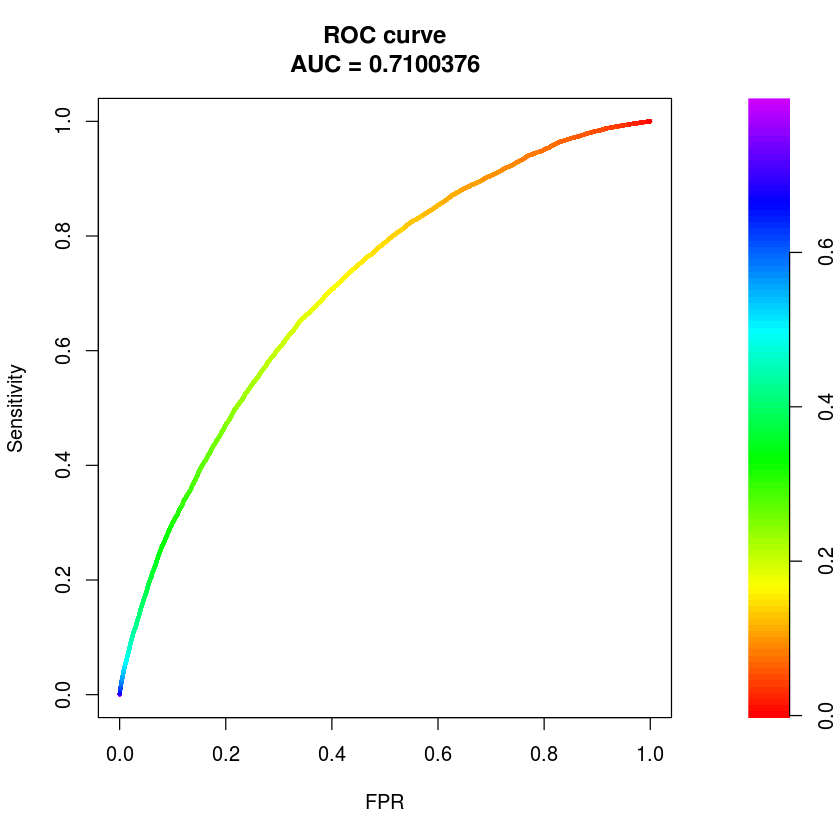

In [39]:
xgb.mono.opt.roc <- roc.curve(scores.class0 = xgb.mono.opt.pred.fg, scores.class1 = xgb.mono.opt.pred.bg, curve = T)
plot(xgb.mono.opt.roc)

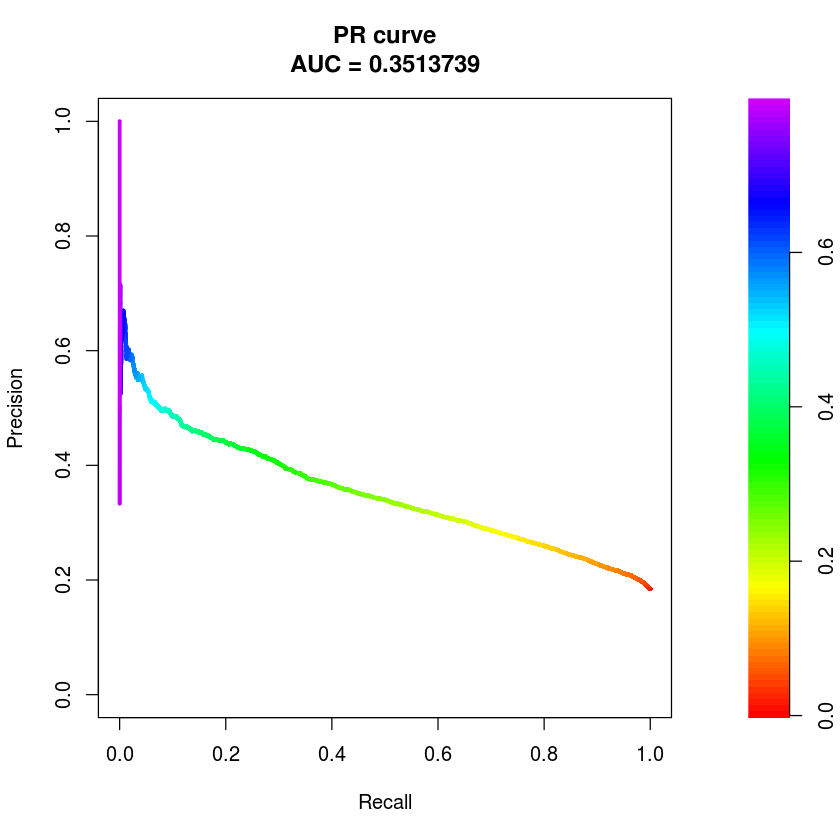

In [40]:
xgb.mono.opt.prc <- pr.curve(scores.class0 = xgb.mono.opt.pred.fg, scores.class1 = xgb.mono.opt.pred.bg, curve = T)
plot(xgb.mono.opt.prc)

**Calculate AUC**

In [41]:
xgb.mono.opt.auc <- auc(roc(y_test$default, xgb.mono.opt.pred))
xgb.mono.opt.auc

Area under the curve: 0.71

**Calculate F-score**

In [42]:
xgb.mono.opt.f1 <- F1_Score(ifelse(xgb.mono.opt.pred > xgb.mono.CSL.cv.opt2.threshold, 1, 0), ifelse(y_test$default, 1, 0), positive = "0")
xgb.mono.opt.f1

[1] 0.8100236

**Generate and Save Confusion Matrix**

In [43]:
xgb.mono.opt.cm <- confusionMatrix(table(xgb.mono.opt.pred > xgb.mono.CSL.cv.opt2.threshold, y_test$default))
xgb.mono.opt.cm

Confusion Matrix and Statistics

       
        FALSE  TRUE
  FALSE 31371  4344
  TRUE  10371  5073
                                          
               Accuracy : 0.7124          
                 95% CI : (0.7084, 0.7163)
    No Information Rate : 0.8159          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2326          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7515          
            Specificity : 0.5387          
         Pos Pred Value : 0.8784          
         Neg Pred Value : 0.3285          
             Prevalence : 0.8159          
         Detection Rate : 0.6132          
   Detection Prevalence : 0.6981          
      Balanced Accuracy : 0.6451          
                                          
       'Positive' Class : FALSE           
                                       

**Calculate Feature Importance/Influence**

In [44]:
xgb.mono.opt.imp <- xgb.importance(model = xgb.mono.opt.mdl)
print(xgb.mono.opt.imp)

                                   Feature         Gain        Cover
 1:                               int_rate 4.902382e-01 9.296981e-02
 2:                             annual_inc 1.275431e-01 1.104498e-01
 3:                                    dti 6.876151e-02 6.278423e-02
 4:                              term_36MO 3.690891e-02 1.990864e-02
 5:                              loan_amnt 2.854673e-02 5.597795e-02
 6:                              term_60MO 2.709661e-02 6.662207e-03
 7:                                grade_A 2.514980e-02 6.036515e-03
 8:                              total_acc 2.491878e-02 9.758906e-02
 9:                            installment 1.754920e-02 5.242464e-02
10:                    home_ownership_RENT 1.522776e-02 1.870599e-02
11:                gross_operating_surplus 1.435303e-02 2.731568e-02
12:                 purpose_SMALL_BUSINESS 1.306090e-02 2.705396e-02
13:                      real_gdp_by_state 1.148905e-02 5.899623e-02
14:                               

**Plot Importance/Influence**

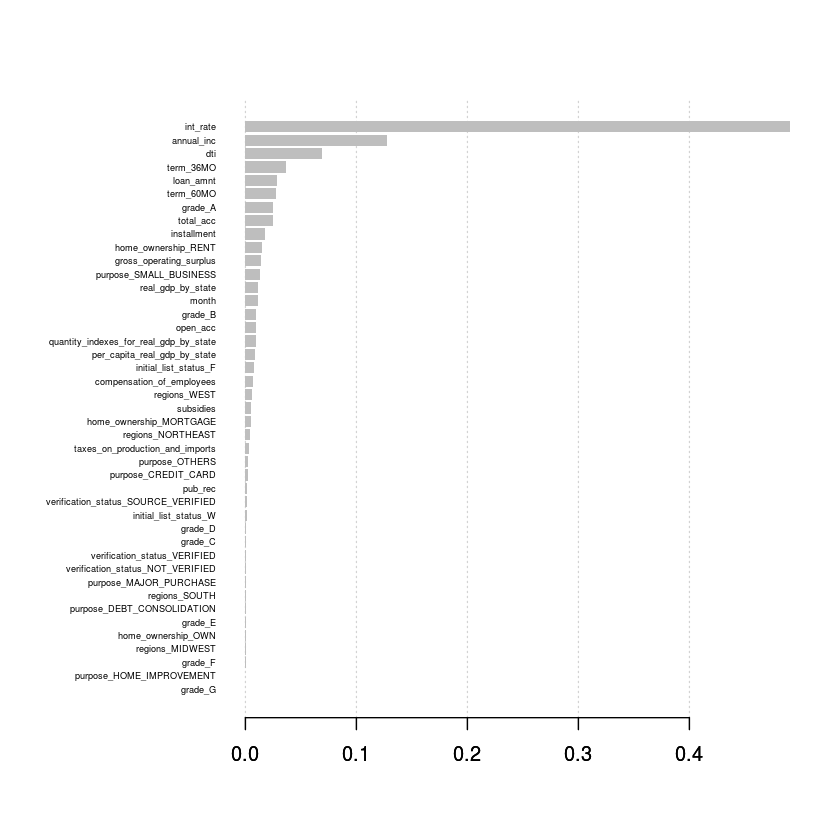

In [45]:
xgb.plot.importance(importance_matrix = xgb.mono.opt.imp)

**Dump Tree**

In [46]:
xgb.dump(xgb.mono.opt.mdl, with.stats = T, fname = "./models/new.xgb.mono.opt.tree.costopt.txt")

Warning message:
“'with.stats' is deprecated.
Use 'with_stats' instead.
See help("Deprecated") and help("xgboost-deprecated").”

[1] TRUE

**Save Model**

In [47]:
xgb.save(xgb.mono.opt.mdl, "./models/new.xgb.mono.opt.costopt.mdl")

[1] TRUE

**Partial Graph (for 3 top vars)**

In [75]:
stime <- Sys.time()
xgb.mono.opt.mdl.1p <- partial(xgb.mono.opt.mdl, pred.var = "int_rate", train = x_train.1hot,
                                 grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 2.014887 mins


In [76]:
stime <- Sys.time()
xgb.mono.opt.mdl.2p <- partial(xgb.mono.opt.mdl, pred.var = "quantity_indexes_for_real_gdp_by_state", train = x_train.1hot,
                                 grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 2.047591 mins


In [77]:
stime <- Sys.time()
xgb.mono.opt.mdl.3p <- partial(xgb.mono.opt.mdl, pred.var = "annual_inc", train = x_train.1hot,
                                 grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 1.983705 mins


#### 4.1.4) Calculate Model Relative Losses

**Losses ($L$)**: We cannot calculate the Loss Given Default (LGD) or Exposure to Default (EAD) precisely because we don't know what is the value of the collateral for each loan and administrative costs associated to a default so we are going to assume it's `loan_amnt` which is potentially a larger amount.

**Returns ($R$)**: We cannot calculate the Return on Allocated Equity (ROE) precisely because to do this we would need to factor cost of funds, income taxes and other costs associated in producing this money but we can calculate how much money is _yielded by the interest of each loan_ should it go to full term. Although this can be calculated using the compounded annualized `int_rate` on the `loan_amnt` for the duration of the `term` and deduct the `loan_amnt`. It's far easier to just leverage the `installment` column like this:

(`installment` * `term`) - `loan_amnt`

So I devised a way to best depict the relative amount of losses like this:

Cost Ratio = $\Large{\frac{L(FN) + R(FP)}{R(TN+FP)}}$ 

Which is the ratio produced by bad predictions over the total amount made by if everything was hypothetically a good prediction. In other words the total lost loan principals by false negatives plus the total lost in revenue by false positives over the total produced in revenue by all negatives (non-defaults).

On the other hand, we also used the profit lift ratio which was used for Bayesian Optimization of the hyperparameter tuning of the model which is:

Lift Ratio = $\Large{\frac{R(TN) - L(FN)}{\text{naïve: } R(TN)  - L(FN)}}$ 

In [48]:
xgb.mono.opt.NIR <- sum(xgb.mono.opt.cm$table[,1])/sum(xgb.mono.opt.cm$table)
xgb.mono.opt.costs <- ((xgb.mono.opt.cm$table[1,2]*mloan_amnt)+(xgb.mono.opt.cm$table[2,1]*mreturns))
xgb.mono.opt.profits <- (xgb.mono.opt.cm$table[1,1]*mreturns) - (xgb.mono.opt.cm$table[1,2]*mloan_amnt)
xgb.mono.opt.naive <- (round(xgb.mono.opt.NIR * sum(xgb.mono.opt.cm$table[1,]),0)*mreturns)-(round((1-xgb.mono.opt.NIR) * sum(xgb.mono.opt.cm$table[1,]),0)*mloan_amnt)
xgb.mono.opt.best <- ((sum(xgb.mono.opt.cm$table[,1])*mreturns))
xgb.mono.opt.worst <- (sum(xgb.mono.opt.cm$table[,1])*mreturns)+(sum(xgb.mono.opt.cm$table[,2])*mloan_amnt)
xgb.mono.opt.lift.ratio <- xgb.mono.opt.profits / xgb.mono.opt.naive
xgb.mono.opt.worst.ratio <- xgb.mono.opt.worst / xgb.mono.opt.best
xgb.mono.opt.cost.ratio <- xgb.mono.opt.costs / xgb.mono.opt.best
xgb.mono.opt.lift.ratio

[1] 2.261757

In [86]:
threshs <- seq(0.0125, 0.325, by = 0.0025)
crs <- c()
rets <- c()
for(i in 1:length(threshs)) {
    cm <- confusionMatrix(table(xgb.mono.opt.pred > threshs[i], y_test$default))
    nir <- sum(cm$table[,1])/sum(cm$table)
    cr <-  ((cm$table[1,2]*mloan_amnt)+(cm$table[2,1]*mreturns)) / (sum(cm$table[,1])*mreturns)
    pr <-  (cm$table[1,1]*mreturns) - (cm$table[1,2]*mloan_amnt)
    nv <- (round(nir * sum(cm$table[1,]),0)*mreturns)-(round((1-nir) * sum(cm$table[1,]),0)*mloan_amnt)
    print(paste(threshs[i],cr,sum(cm$table[,1])*mreturns))
    crs <- c(crs,cr)
    rets <- c(rets, sum(cm$table[1,])*mreturns)
}
min(crs) #xgb.mono.CSL.cv.opt2.threshold = 0.185

[1] "0.0125 0.995266358517244 172000149.549375"
[1] "0.015 0.992233641762579 172000149.549375"
[1] "0.0175 0.988786913521992 172000149.549375"
[1] "0.02 0.984049558808822 172000149.549375"
[1] "0.0225 0.979076350462954 172000149.549375"
[1] "0.025 0.974924417270298 172000149.549375"
[1] "0.0275 0.97015264482177 172000149.549375"
[1] "0.03 0.964552849401399 172000149.549375"
[1] "0.0325 0.958624408191304 172000149.549375"
[1] "0.035 0.953031360589565 172000149.549375"
[1] "0.0375 0.947308068507224 172000149.549375"
[1] "0.04 0.940924450257217 172000149.549375"
[1] "0.0425 0.93490693012051 172000149.549375"
[1] "0.045 0.927848811423376 172000149.549375"
[1] "0.0475 0.922360694331538 172000149.549375"
[1] "0.05 0.915504011531746 172000149.549375"
[1] "0.0525 0.908110499226257 172000149.549375"
[1] "0.055 0.900979153185801 172000149.549375"
[1] "0.0575 0.892954661933199 172000149.549375"
[1] "0.06 0.885809141613283 172000149.549375"
[1] "0.0625 0.877699284664483 172000149.549375"
[1] "0.06

[1] 0.588805

### 4.2) Non-Monotonic Constrained XGBoost

#### 4.2.1) Perform Hyperparameter Tuning with Bayesian Optimization and Cross Validation on the Training Data Sample

Optimize the PR AUC

In [49]:
xgb.cv.bayes <- function(nround, max_depth, min_child_weight, eta, gamma) { # subsample, colsample_bytree, max_delta_step
    params <- list(
                    booster = "gbtree", #"gblinear", "dart"
                    max_depth = max_depth,
                    min_child_weight = min_child_weight,
                    eta = eta,
                    gamma = gamma,
                    subsample = 0.9, #subsample, 
                    colsample_bytree = 0.8, #colsample_bytree,
                    #max_delta_step = max_delta_step,
                    #lambda = 1, 
                    #alpha = 0,
                    objective = "binary:logistic",
                    eval_metric = "aucpr"
                 )
    cv <- xgb.cv(params = params, data = dtrain.1hot, folds = cv_folds, nrounds = 500, 
                 early_stopping_rounds = 10, maximize = TRUE, verbose = TRUE, print_every_n=20)
    return(list(Score = cv$evaluation_log$test_aucpr_mean[cv$best_iteration], Pred=cv$best_iteration))
}

In [50]:
stime <- Sys.time()
xgb.cv.bayes.opt <- BayesianOptimization(xgb.cv.bayes,
                              bounds = list(max_depth = c(3L, 15L), 
                                            min_child_weight = c(1L, 7L),
                                            eta=c(0.05, 0.3),
                                            gamma = c(0.0, 0.4) #,
                                            #subsample = c(0.6, 0.9),
                                            #colsample_bytree=c(0.3, 0.7),
                                            #max_delta_step=c(1L, 10L)
                                        ),
                              init_grid_dt = NULL, init_points = 10, n_iter = 10,
                              acq = "ucb", kappa = 2.576, eps = 0.0, verbose = FALSE)
print(Sys.time() - stime)


 Best Parameters Found: 
Round = 19	max_depth = 5.0000	min_child_weight = 2.0000	eta = 0.0692	gamma = 0.1934	Value = 0.3575 
Time difference of 27.4368 mins


**Bayesian Optimization History**

In [51]:
xgb.cv.bayes.opt$History

Round,max_depth,min_child_weight,eta,gamma,Value
1,8,6,0.19108176,0.04066041,0.3496600
2,4,5,0.11149073,0.04746462,0.3562832
3,11,5,0.23826744,0.36749836,0.3368512
4,15,5,0.12306733,0.26890431,0.3307060
5,7,3,0.25608782,0.13806367,0.3484536
6,10,2,0.19699559,0.16508066,0.3384774
7,4,2,0.15987103,0.36876282,0.3561296
8,3,4,0.18723189,0.01477852,0.3558280
9,4,4,0.19243697,0.13068782,0.3552168
10,13,7,0.22006562,0.16888285,0.3305362


**Bayesian Optimization Best Parameters**

In [52]:
xgb.cv.bayes.opt$Best_Par

max_depth min_child_weight              eta            gamma 
      5.00000000       2.00000000       0.06918026       0.19339989

**Set Optimal # Rounds**

In [53]:
xgb.cv.bayes.opt.nrounds <- xgb.cv.bayes.opt$Pred[[which.max(xgb.cv.bayes.opt$History$Value)]]
xgb.cv.bayes.opt.nrounds

[1] 269

#### 4.1.2) Perform Cost Sensitive Learning with Cross Validation on the Training Data Sample

**Run CSL on a 0.003 threshold interval**

In [54]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1
              )
stime <- Sys.time()
xgb.CSL.cv.opt1 <- CSL(params, dtrain.1hot, 5, xgb.cv.bayes.opt.nrounds, 
                           0.1, 0.69, 0.03, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.1"
[1] "2 : 0.13"
[1] "3 : 0.16"
[1] "4 : 0.19"
[1] "5 : 0.22"
[1] "6 : 0.25"
[1] "7 : 0.28"
[1] "8 : 0.31"
[1] "9 : 0.34"
[1] "10 : 0.37"
[1] "11 : 0.4"
[1] "12 : 0.43"
[1] "13 : 0.46"
[1] "14 : 0.49"
[1] "15 : 0.52"
[1] "16 : 0.55"
[1] "17 : 0.58"
[1] "18 : 0.61"
[1] "19 : 0.64"
[1] "20 : 0.67"
Time difference of 6.826219 mins


**Plot the lift for every threshold in the 0.10-0.69 range**

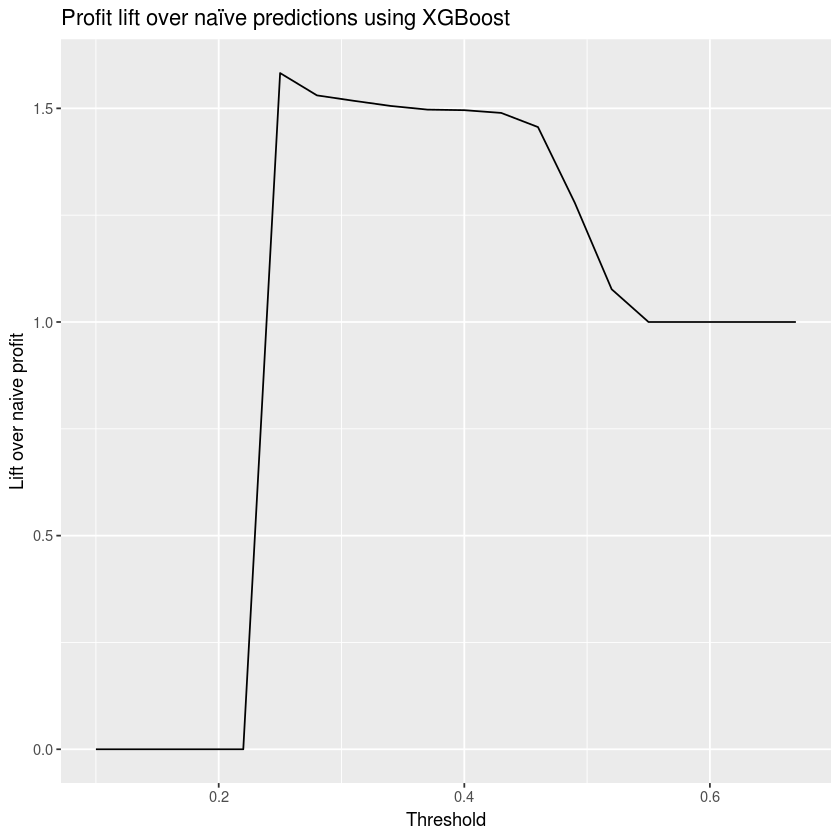

In [55]:
xgb.CSL.cv.opt1.df <- as.data.frame(xgb.CSL.cv.opt1)
ggplot(xgb.CSL.cv.opt1.df, aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.03 scale**

In [56]:
xgb.CSL.cv.opt1.threshold <- xgb.CSL.cv.opt1.df$thresholds[which.max(xgb.CSL.cv.opt1.df$performance)]
xgb.CSL.cv.opt1.threshold

[1] 0.25

**Get more granular at a 0.005 threshold level**

In [57]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1,
                monotone_constraints = mono
              )
stime <- Sys.time()
xgb.CSL.cv.opt2 <- CSL(params, dtrain.1hot, 5, xgb.cv.bayes.opt.nrounds, 
                           xgb.CSL.cv.opt1.threshold - 0.03, xgb.CSL.cv.opt1.threshold + 0.03, 0.005, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.22"
[1] "2 : 0.225"
[1] "3 : 0.23"
[1] "4 : 0.235"
[1] "5 : 0.24"
[1] "6 : 0.245"
[1] "7 : 0.25"
[1] "8 : 0.255"
[1] "9 : 0.26"
[1] "10 : 0.265"
[1] "11 : 0.27"
[1] "12 : 0.275"
[1] "13 : 0.28"
Time difference of 9.619052 mins


**Plot the lift for every threshold in the 0.13-0.19 range**

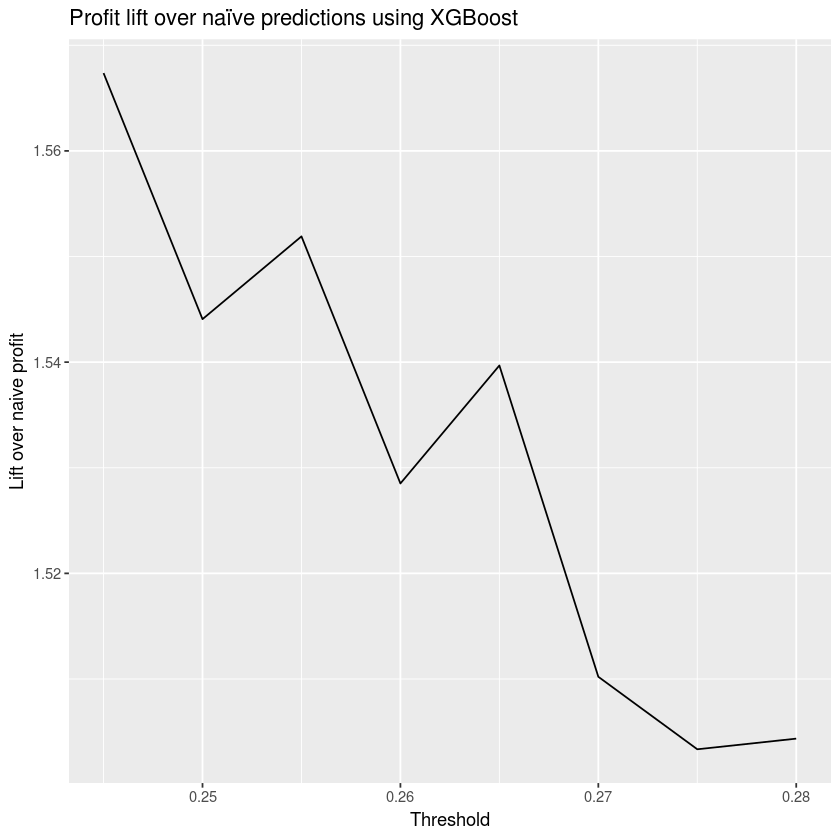

In [58]:
xgb.CSL.cv.opt2.df <- as.data.frame(xgb.CSL.cv.opt2)
ggplot(xgb.CSL.cv.opt2.df[which(xgb.CSL.cv.opt2.df$performance>0),], aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.005 scale**

In [59]:
xgb.CSL.cv.opt2.threshold <- xgb.CSL.cv.opt2.df$thresholds[which.max(xgb.CSL.cv.opt2.df$performance)]
xgb.CSL.cv.opt2.threshold

[1] 0.245

#### 4.2.2) Run & Test XGBoost on Optimal Params but on Full Training Set

**Set Optimal Params for Non-Monotonic**

In [60]:
xgb.cv.bayes.opt.params <- list(
    booster = "gbtree",
    max_depth = xgb.cv.bayes.opt$Best_Par["max_depth"],
    min_child_weight = xgb.cv.bayes.opt$Best_Par["min_child_weight"],
    eta = xgb.cv.bayes.opt$Best_Par["eta"],
    gamma = xgb.cv.bayes.opt$Best_Par["gamma"],
    subsample = 0.9, #xgb.cv.bayes.opt$Best_Par["subsample"],
    colsample_bytree = 0.8, #xgb.cv.bayes.opt$Best_Par["colsample_bytree"],
    #max_delta_step = xgb.cv.bayes.opt$Best_Par["max_delta_step"], 
    objective = "binary:logistic",
    eval_metric=c("logloss", "auc", "aucpr", "error")
)

**Train model on full training set**

In [61]:
stime <- Sys.time()
xgb.opt.mdl <- xgb.train(params = xgb.cv.bayes.opt.params, nrounds = xgb.cv.bayes.opt.nrounds, data = dtrain.1hot, 
                              verbose=1, print_every_n=30)
print(Sys.time() - stime)

Time difference of 20.16907 secs


**Get Predictions using Test Dataset**

In [62]:
xgb.opt.pred <- predict(xgb.opt.mdl, as.matrix(x_test.1hot))

**Plot ROC Curve**

In [63]:
xgb.opt.pred.fg <- xgb.opt.pred[y_test$default==TRUE]
xgb.opt.pred.bg <- xgb.opt.pred[y_test$default==FALSE]

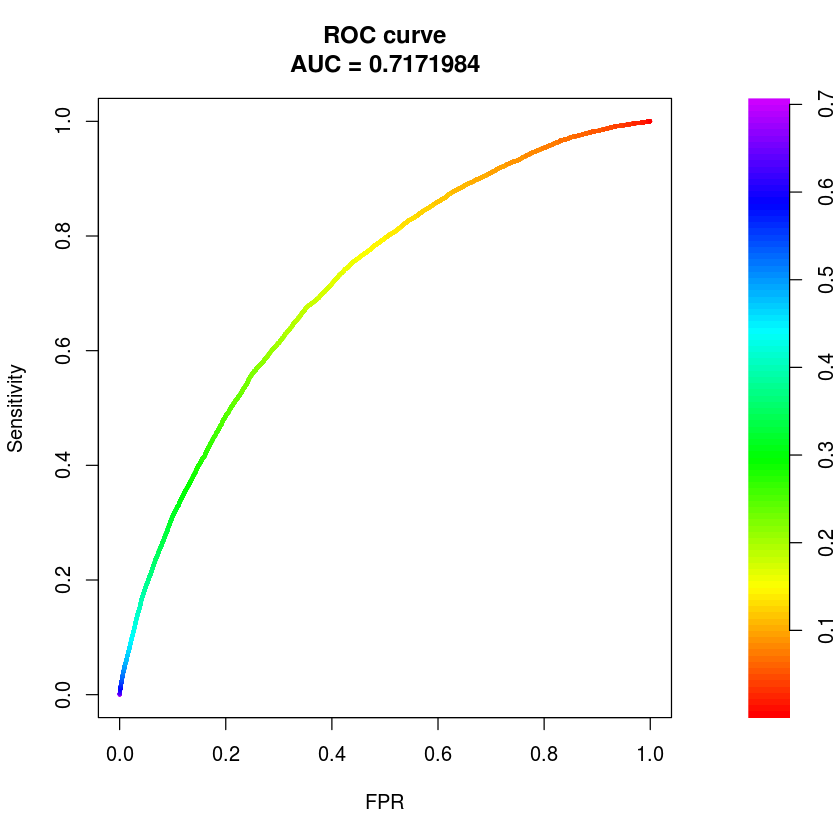

In [64]:
xgb.opt.roc <- roc.curve(scores.class0 = xgb.opt.pred.fg, scores.class1 = xgb.opt.pred.bg, curve = T)
plot(xgb.opt.roc)

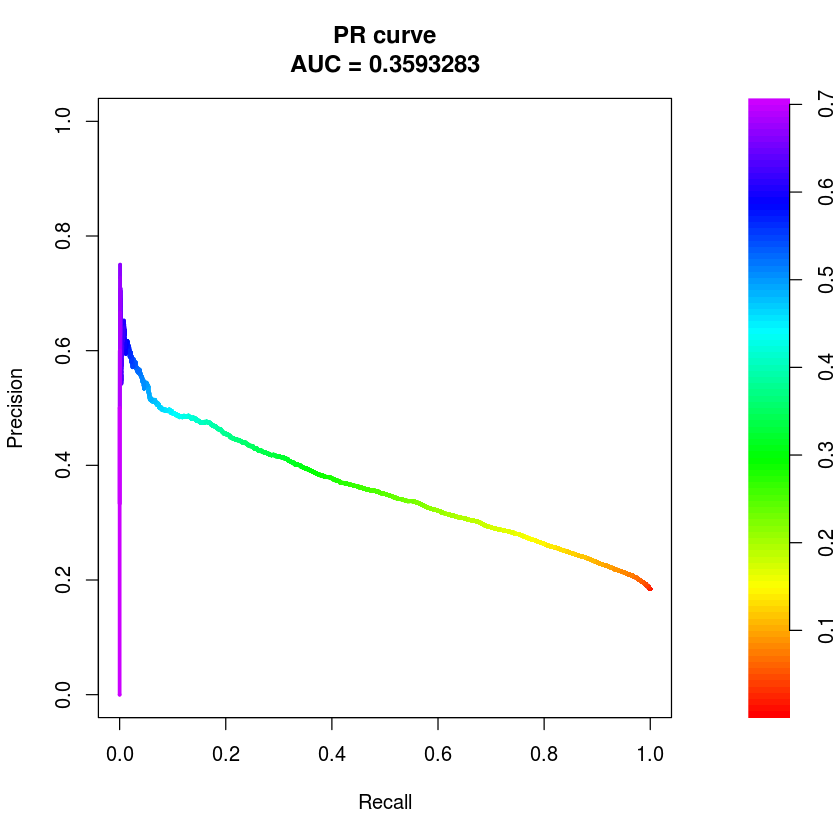

In [65]:
xgb.opt.prc <- pr.curve(scores.class0 = xgb.opt.pred.fg, scores.class1 = xgb.opt.pred.bg, curve = T)
plot(xgb.opt.prc)

**Calculate AUC**

In [66]:
xgb.opt.auc <- auc(roc(y_test$default, xgb.opt.pred))
xgb.opt.auc

Area under the curve: 0.7172

**Calculate F-score**

In [67]:
xgb.opt.f1 <- F1_Score(ifelse(xgb.opt.pred > 0.5, 1, 0), ifelse(y_test$default, 1, 0), positive = "0")
xgb.opt.f1

[1] 0.8984402

**Generate and Save Confusion Matrix**

In [68]:
xgb.opt.cm <- confusionMatrix(table(xgb.opt.pred > xgb.CSL.cv.opt2.threshold, y_test$default))
xgb.opt.cm

Confusion Matrix and Statistics

       
        FALSE  TRUE
  FALSE 33078  4734
  TRUE   8664  4683
                                          
               Accuracy : 0.7381          
                 95% CI : (0.7343, 0.7419)
    No Information Rate : 0.8159          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2494          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7924          
            Specificity : 0.4973          
         Pos Pred Value : 0.8748          
         Neg Pred Value : 0.3509          
             Prevalence : 0.8159          
         Detection Rate : 0.6466          
   Detection Prevalence : 0.7391          
      Balanced Accuracy : 0.6449          
                                          
       'Positive' Class : FALSE           
                                       

**Calculate Feature Importance/Influence**

In [69]:
xgb.opt.imp <- xgb.importance(model = xgb.opt.mdl)
print(xgb.opt.imp)

                                   Feature         Gain       Cover   Frequency
 1:                               int_rate 0.4285738018 0.136197849 0.083989145
 2:                             annual_inc 0.1137493599 0.112107753 0.117503392
 3:                                    dti 0.0702980480 0.081522529 0.110990502
 4:                              term_36MO 0.0437926855 0.023491593 0.017639077
 5: quantity_indexes_for_real_gdp_by_state 0.0344446469 0.070826970 0.060786974
 6:                            installment 0.0336952353 0.061038075 0.079104478
 7:                              loan_amnt 0.0289468499 0.047709805 0.056445047
 8:                              total_acc 0.0239398821 0.047464551 0.053867028
 9:                gross_operating_surplus 0.0168217951 0.039236935 0.037720488
10:           per_capita_real_gdp_by_state 0.0163410237 0.043880701 0.040434193
11:                      real_gdp_by_state 0.0159090802 0.038936850 0.038127544
12:                                  mon

**Plot Importance/Influence**

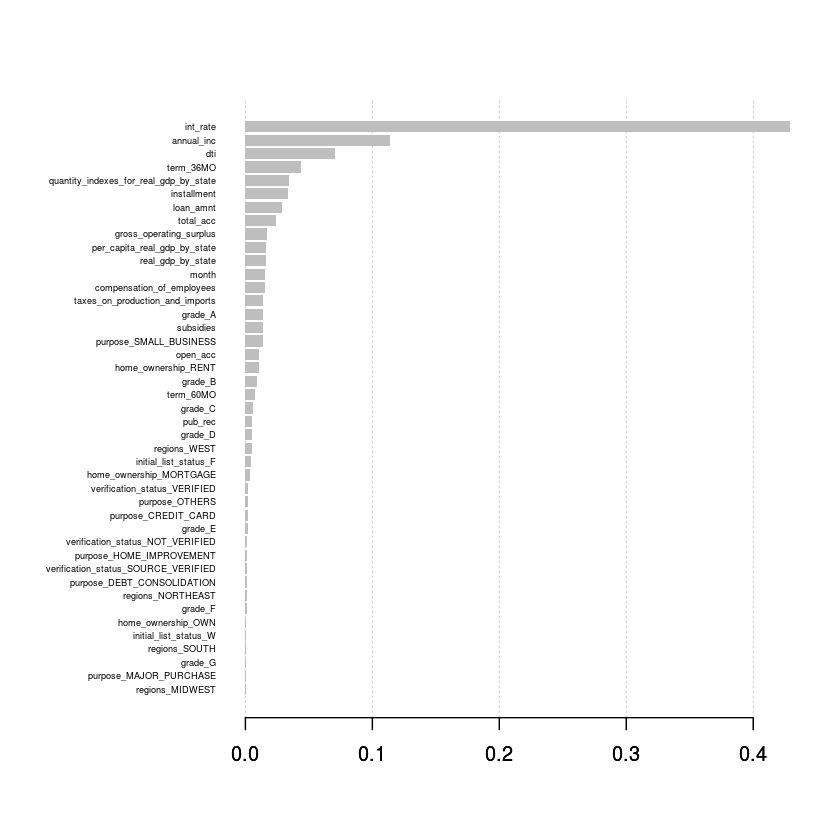

In [70]:
xgb.plot.importance(importance_matrix = xgb.opt.imp)

**Dump Tree**

In [71]:
xgb.dump(xgb.opt.mdl, with.stats = T, fname = "./models/new.xgb.opt.tree.costopt.txt")

Warning message:
“'with.stats' is deprecated.
Use 'with_stats' instead.
See help("Deprecated") and help("xgboost-deprecated").”

[1] TRUE

**Save Model**

In [72]:
xgb.save(xgb.opt.mdl, "./models/new.xgb.opt.costopt.mdl")

[1] TRUE

**Partial Graph (for 3 top vars)**

In [78]:
stime <- Sys.time()
xgb.opt.mdl.1p <- partial(xgb.opt.mdl, pred.var = "int_rate", train = x_train.1hot,
                         grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 3.70379 mins


In [79]:
stime <- Sys.time()
xgb.opt.mdl.2p <- partial(xgb.opt.mdl, pred.var = "quantity_indexes_for_real_gdp_by_state", train = x_train.1hot,
                         grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 3.781479 mins


In [80]:
stime <- Sys.time()
xgb.opt.mdl.3p <- partial(xgb.opt.mdl, pred.var = "annual_inc", train = x_train.1hot,
                         grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 3.842599 mins


#### 4.2.4) Calculate Model Relative Losses

In [73]:
xgb.opt.NIR <- sum(xgb.opt.cm$table[,1])/sum(xgb.opt.cm$table)
xgb.opt.costs <- ((xgb.opt.cm$table[1,2]*mloan_amnt)+(xgb.opt.cm$table[2,1]*mreturns))
xgb.opt.profits <- (xgb.opt.cm$table[1,1]*mreturns) - (xgb.opt.cm$table[1,2]*mloan_amnt)
xgb.opt.naive <- (round(xgb.opt.NIR * sum(xgb.opt.cm$table[1,]),0)*mreturns)-(round((1-xgb.opt.NIR) * sum(xgb.opt.cm$table[1,]),0)*mloan_amnt)
xgb.opt.best <- ((sum(xgb.opt.cm$table[,1])*mreturns))
xgb.opt.worst <- (sum(xgb.opt.cm$table[,1])*mreturns)+(sum(xgb.opt.cm$table[,2])*mloan_amnt)
xgb.opt.lift.ratio <- xgb.opt.profits / xgb.opt.naive
xgb.opt.worst.ratio <- xgb.opt.worst / xgb.opt.best
xgb.opt.cost.ratio <- xgb.opt.costs / xgb.opt.best
xgb.opt.lift.ratio

[1] 2.18965

In [169]:
threshs <- seq(0.15, 0.35, by = 0.0025)
crs <- c()
rets <- c()
for(i in 1:length(threshs)) {
    cm <- confusionMatrix(table(xgb.opt.pred > threshs[i], y_test$default))
    cr <- ((cm$table[1,2]*mloan_amnt)+(cm$table[2,1]*mreturns)) / (sum(cm$table[,1])*mreturns)
    print(paste(threshs[i],cr,sum(cm$table[,1])*mreturns))
    crs <- c(crs,cr)
    rets <- c(rets, sum(cm$table[1,])*mreturns)
}
min(crs) #xgb.CSL.cv.opt2.threshold = 0.16 #0.43
max(rets)

[1] "0.15 0.244203619308192 350083389.6"
[1] "0.1525 0.244255501804019 350083389.6"
[1] "0.155 0.243686691040882 350083389.6"
[1] "0.1575 0.243046323612264 350083389.6"
[1] "0.16 0.242668475351165 350083389.6"
[1] "0.1625 0.242810807154045 350083389.6"
[1] "0.165 0.243311139375463 350083389.6"
[1] "0.1675 0.243257129386524 350083389.6"
[1] "0.17 0.24356916704168 350083389.6"
[1] "0.1725 0.243464770200568 350083389.6"
[1] "0.175 0.243434597960714 350083389.6"
[1] "0.1775 0.24361939964489 350083389.6"
[1] "0.18 0.243677052194538 350083389.6"
[1] "0.1825 0.243753119785264 350083389.6"
[1] "0.185 0.244184693531658 350083389.6"
[1] "0.1875 0.244059257131918 350083389.6"
[1] "0.19 0.244016135977221 350083389.6"
[1] "0.1925 0.243954426108539 350083389.6"
[1] "0.195 0.244624811528047 350083389.6"
[1] "0.1975 0.245128115612829 350083389.6"
[1] "0.2 0.245570447938784 350083389.6"
[1] "0.2025 0.245951851924139 350083389.6"
[1] "0.205 0.246240399176025 350083389.6"
[1] "0.2075 0.247080707538945 35

[1] 0.2426685

[1] 369577056

### 4.3) Compare Models

#### 4.3.1) Plot Monotonic Constraint Differences for Top 3 features

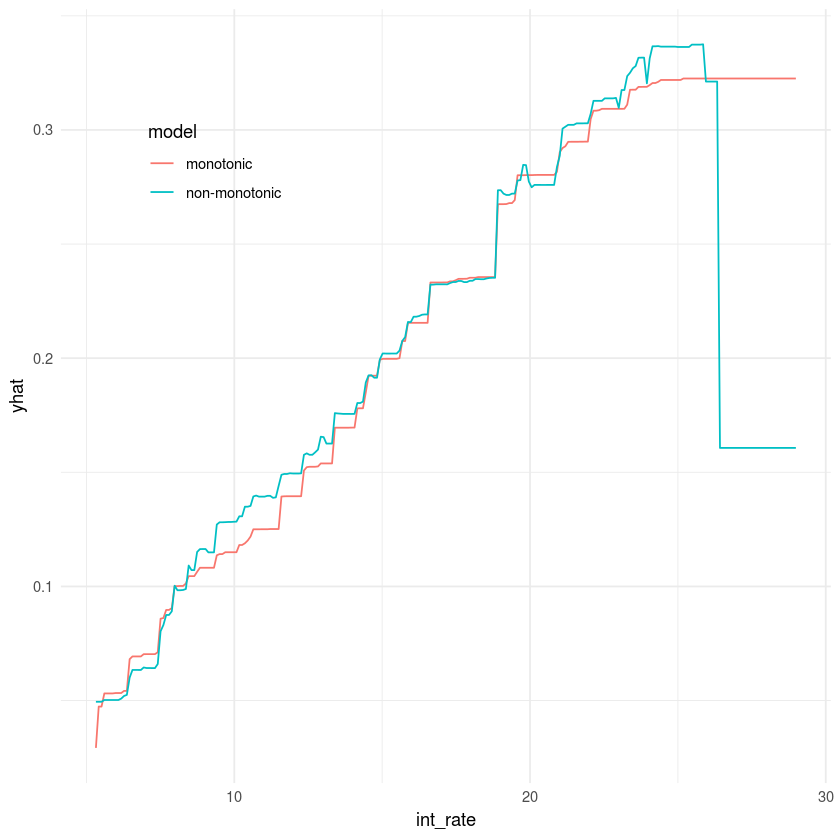

In [81]:
xgb.mono.opt.mdl.1p.df <- as.data.frame(xgb.mono.opt.mdl.1p$panel.args)
xgb.mono.opt.mdl.1p.df$model <- "monotonic"
xgb.opt.mdl.1p.df <- as.data.frame(xgb.opt.mdl.1p$panel.args)
xgb.opt.mdl.1p.df$model <- "non-monotonic"
xgb.opt.mdl.1p.df <- rbind.data.frame(xgb.mono.opt.mdl.1p.df, xgb.opt.mdl.1p.df)
ggplot(xgb.opt.mdl.1p.df, aes(x=x, y=y)) + geom_line(aes(colour = model)) +
            xlab("int_rate") + ylab("yhat") + theme_minimal() + theme(legend.position=c(0.2, 0.8))

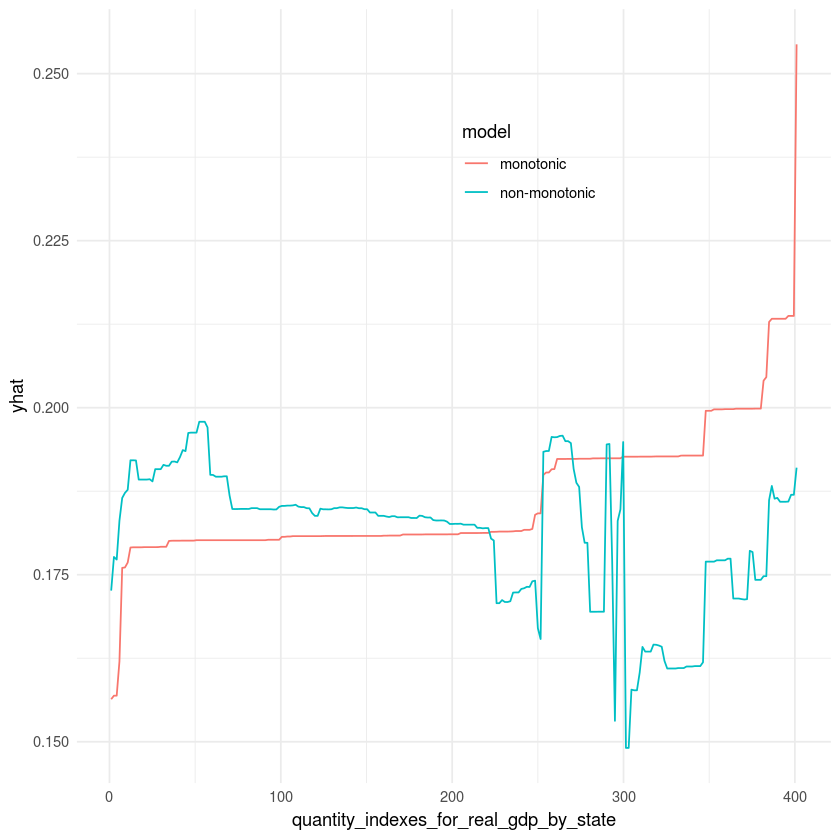

In [82]:
xgb.mono.opt.mdl.2p.df <- as.data.frame(xgb.mono.opt.mdl.2p$panel.args)
xgb.mono.opt.mdl.2p.df$model <- "monotonic"
xgb.opt.mdl.2p.df <- as.data.frame(xgb.opt.mdl.2p$panel.args)
xgb.opt.mdl.2p.df$model <- "non-monotonic"
xgb.opt.mdl.2p.df <- rbind.data.frame(xgb.mono.opt.mdl.2p.df, xgb.opt.mdl.2p.df)
ggplot(xgb.opt.mdl.2p.df, aes(x=x, y=y)) + geom_line(aes(colour = model)) +
            xlab("quantity_indexes_for_real_gdp_by_state") + ylab("yhat") + theme_minimal() + theme(legend.position=c(0.6, 0.8))

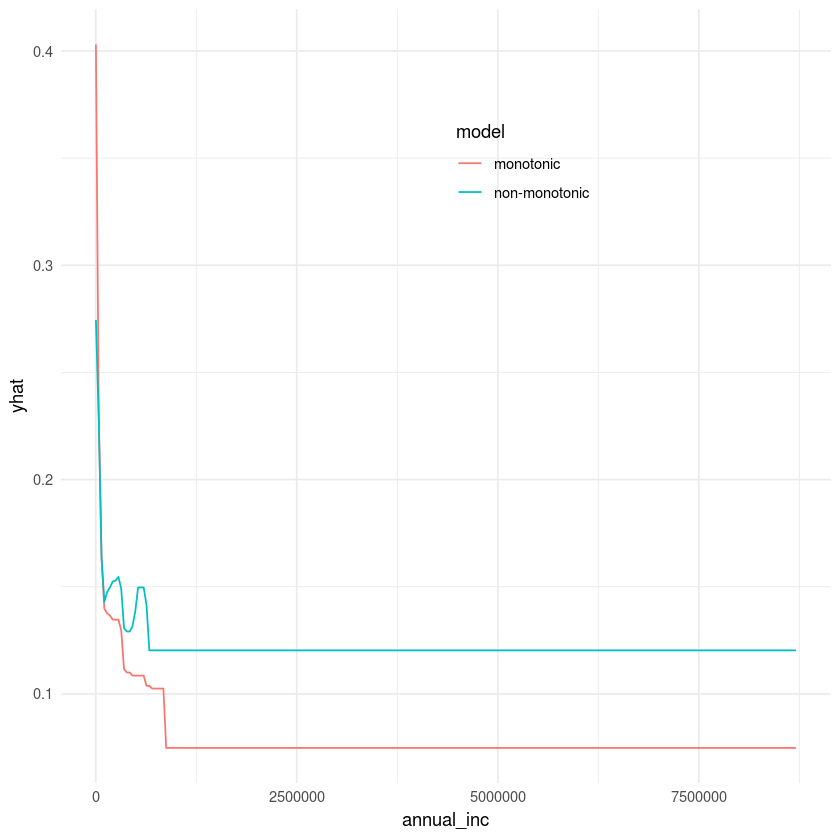

In [83]:
xgb.mono.opt.mdl.3p.df <- as.data.frame(xgb.mono.opt.mdl.3p$panel.args)
xgb.mono.opt.mdl.3p.df$model <- "monotonic"
xgb.opt.mdl.3p.df <- as.data.frame(xgb.opt.mdl.3p$panel.args)
xgb.opt.mdl.3p.df$model <- "non-monotonic"
xgb.opt.mdl.3p.df <- rbind.data.frame(xgb.mono.opt.mdl.3p.df, xgb.opt.mdl.3p.df)
ggplot(xgb.opt.mdl.3p.df, aes(x=x, y=y)) + geom_line(aes(colour = model)) +
            xlab("annual_inc") + ylab("yhat") + theme_minimal() + theme(legend.position=c(0.6, 0.8))

#### 4.3.2) Compare Metrics

In [74]:
options(scipen=999)
makeCMStatsCol <- function(cm, colname, costs, best, worst, ratio){
    cm.df1 <- as.data.frame(cm$overall)
    colnames(cm.df1) <- c(colname)
    cm.df2 <- as.data.frame(cm$byClass) 
    colnames(cm.df2) <- c(colname)
    cm.df3 <- data.frame(costs)
    row.names(cm.df3) <- c("COSTS")
    colnames(cm.df3) <- c(colname)
    cm.df4 <- data.frame(best)
    row.names(cm.df4) <- c("BEST CASE")
    colnames(cm.df4) <- c(colname)
    cm.df5 <- data.frame(worst)
    row.names(cm.df5) <- c("LIFT RATIO")
    colnames(cm.df5) <- c(colname)
    cm.df6 <- data.frame(ratio)
    row.names(cm.df6) <- c("COST RATIO")
    colnames(cm.df6) <- c(colname)
    cm.df <- rbind(cm.df1, cm.df2, cm.df3, cm.df4, cm.df5, cm.df6) 
    cm.df <- round(cm.df, 5)
    return(cm.df)
}
cbind(
    makeCMStatsCol(xgb.mono.opt.cm, "Monotonic XGBoost", xgb.mono.opt.costs, xgb.mono.opt.best, xgb.mono.opt.lift.ratio, xgb.mono.opt.cost.ratio),
    makeCMStatsCol(xgb.opt.cm, "Non-Monotonic XGBoost", xgb.opt.costs, xgb.opt.best, xgb.opt.lift.ratio, xgb.opt.cost.ratio)
)

,Monotonic XGBoost,Non-Monotonic XGBoost
Accuracy,0.71237,0.73811
Kappa,0.23261,0.24943
AccuracyLower,0.70842,0.73428
AccuracyUpper,0.71629,0.74192
AccuracyNull,0.81593,0.81593
AccuracyPValue,1.00000,1.00000
McnemarPValue,0.00000,0.00000
Sensitivity,0.75155,0.79244
Specificity,0.53871,0.49729
Pos Pred Value,0.87837,0.87480


### 4.4) Export Predictions

In [89]:
xgb.mono.opt.pred.df <- as.data.frame(xgb.mono.opt.pred > xgb.mono.CSL.cv.opt2.threshold)
colnames(xgb.mono.opt.pred.df) <- c("XGB_mono_pred")

In [91]:
xgb.opt.pred.df <- as.data.frame(xgb.opt.pred > xgb.CSL.cv.opt2.threshold)
colnames(xgb.opt.pred.df) <- c("XGB_pred")

In [93]:
write.csv(xgb.mono.opt.pred.df, file = "./pred/XGB_mono_pred.csv")
write.csv(xgb.opt.pred.df, file = "./pred/XGB_pred.csv")

## XNN

In [94]:
xnn.prob.df <- read.csv(file="./pred/XNN_prob.csv", header=TRUE, sep=",")
glimpse(xnn.prob.df)

Observations: 51,159
Variables: 2
$ X        <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…
$ XNN_prob <dbl> 0.15377873, 0.27356870, 0.15619719, 0.18449620, 0.14224678, …


Find optimal Threshold

In [121]:
xnn.res.df <- data.frame(Threshold=0, CR=0, Profit=0, stringsAsFactors=FALSE)
threshs <- seq(0.03, 0.5725, by = 0.0025)
crs <- c()
rets <- c()
for(i in 1:length(threshs)) {
    cm <- confusionMatrix(table(xnn.prob.df$XNN_prob > threshs[i], y_test$default))
    nir <- sum(cm$table[,1])/sum(cm$table)
    cr <-  ((cm$table[1,2]*mloan_amnt)+(cm$table[2,1]*mreturns)) / (sum(cm$table[,1])*mreturns)
    pr <-  (cm$table[1,1]*mreturns) - (cm$table[1,2]*mloan_amnt)
    nv <- (round(nir * sum(cm$table[1,]),0)*mreturns)-(round((1-nir) * sum(cm$table[1,]),0)*mloan_amnt)
    crs <- c(crs,pr)
    rets <- c(rets, sum(cm$table[1,])*mreturns)
    xnn.res.df[nrow(xnn.res.df) + 1,] = list(threshs[i],cr,pr)
}
max(pr) #xgb.mono.CSL.cv.opt2.threshold = 0.035, 0.26

[1] 44674298

In [126]:
xnn.res.df[which(xnn.res.df$Profit > 60000000),] %>% arrange(-Profit)

Threshold,CR,Profit
0.2600,0.6072993,67544575
0.2675,0.6076366,67486564
0.2650,0.6076620,67482203
0.2700,0.6077789,67462081
0.2625,0.6077936,67459561
0.2725,0.6082695,67377705
0.2525,0.6092605,67207247
0.2575,0.6094652,67172036
0.2825,0.6094897,67167823
0.2750,0.6100179,67076973


In [127]:
xnn.cm <- confusionMatrix(table(xnn.prob.df$XNN_prob > 0.26, y_test$default))
xnn.cm

Confusion Matrix and Statistics

       
        FALSE  TRUE
  FALSE 30500  4299
  TRUE  11242  5118
                                             
               Accuracy : 0.6962             
                 95% CI : (0.6922, 0.7002)   
    No Information Rate : 0.8159             
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.2133             
                                             
 Mcnemar's Test P-Value : <0.0000000000000002
                                             
            Sensitivity : 0.7307             
            Specificity : 0.5435             
         Pos Pred Value : 0.8765             
         Neg Pred Value : 0.3128             
             Prevalence : 0.8159             
         Detection Rate : 0.5962             
   Detection Prevalence : 0.6802             
      Balanced Accuracy : 0.6371             
                                             
       'Positive' Class :

Calculate Profit Lift

In [129]:
pr <-  (xnn.cm$table[1,1]*mreturns) - (xnn.cm$table[1,2]*mloan_amnt)
nv <- (round(nir * sum(xnn.cm$table[1,]),0)*mreturns)-(round((1-nir) * sum(xnn.cm$table[1,]),0)*mloan_amnt)
pr / nv

[1] 2.223974

In [130]:
xnn.pred.fg <- xnn.prob.df$XNN_prob[y_test$default==TRUE]
xnn.pred.bg <- xnn.prob.df$XNN_prob[y_test$default==FALSE]

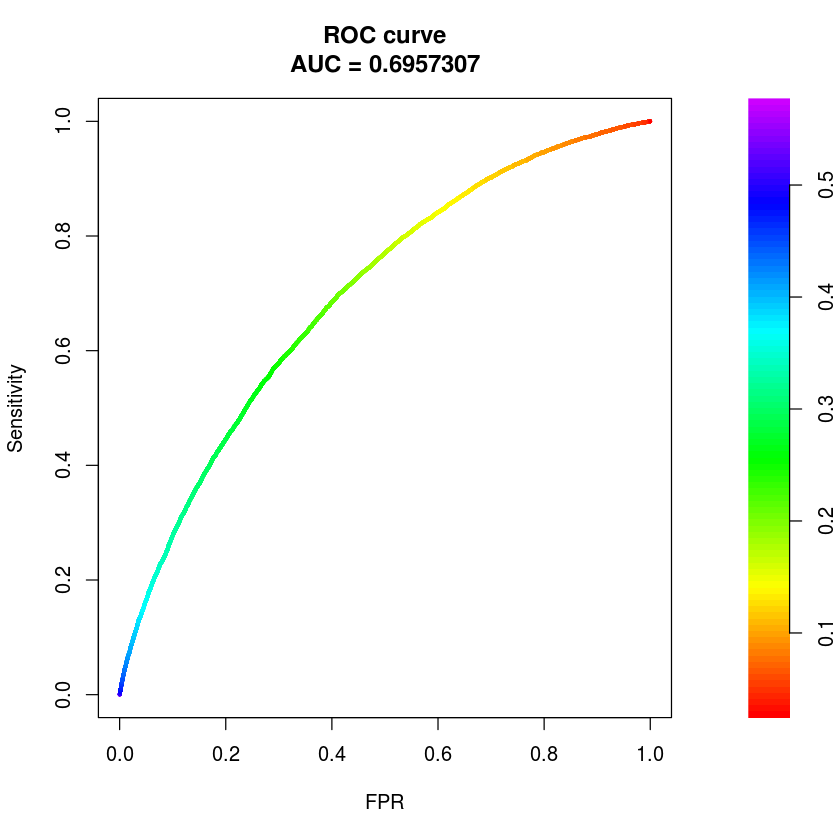

In [131]:
xnn.pred.roc <- roc.curve(scores.class0 = xnn.pred.fg, scores.class1 = xnn.pred.bg, curve = T)
plot(xnn.pred.roc)

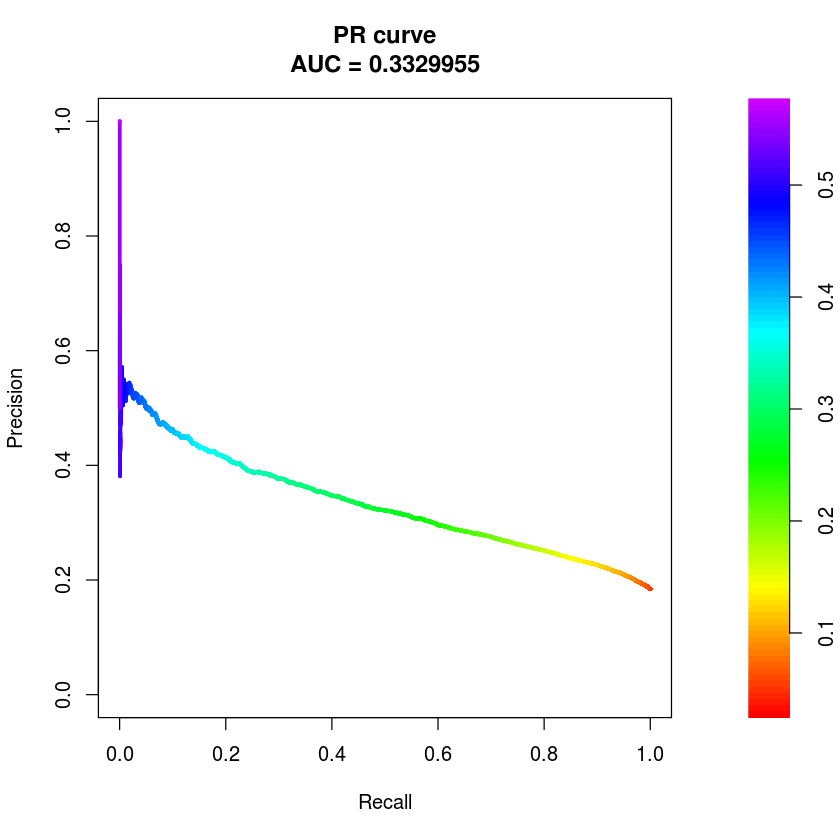

In [132]:
xnn.pred.prc <- pr.curve(scores.class0 = xnn.pred.fg, scores.class1 = xnn.pred.bg, curve = T)
plot(xnn.pred.prc)

Calculate F1 Score

In [133]:
xnn.pred.f1 <- F1_Score(ifelse(xnn.prob.df$XNN_prob > 0.26, 1, 0), ifelse(y_test$default, 1, 0), positive = "0")
xnn.pred.f1

[1] 0.7969585

In [134]:
XNN.pred.df <- as.data.frame(xnn.prob.df$XNN_prob > 0.26)
colnames(XNN.pred.df) <- c("XNN_pred")

In [135]:
write.csv(XNN.pred.df , file = "./pred/XNN_pred.csv")